# **Engineering a Kerr-based Deterministic Cubic Phase Gate via Gaussian Operations in Strawberry Fields**

In [2]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### **Define Useful Functions**

In [3]:
def plot_wigner(state, title = "Wigner Function of State", range = 20):
    fig = plt.figure()
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, P, Z, cmap='RdYlGn', lw=0.5, rstride=1, cstride=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    fig.tight_layout()
    
    plt.show()
    
def ax_plot_wigner(ax, state, title, range=20):
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax.plot_surface(X, P, Z, cmap='RdYlGn', lw=0.5, rstride=1, cstride=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    
# plot  Wigner function on 2D surface
def plot_wigner_2d(state, title = "Wigner Function of State", range = 20):
    fig = plt.figure()
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax = fig.add_subplot(111)
    contour = ax.contourf(X, P, Z, cmap='RdYlGn')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    # add colorbar
    cbar = plt.colorbar(contour)
    cbar.set_label('Wigner Function')
    
    fig.tight_layout()
    
    plt.show()
    
def ax_plot_wigner_2d(ax, state, title, range = 20):
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    contour = ax.contourf(X, P, Z, cmap='RdYlGn')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    # add colorbar
    cbar = plt.colorbar(contour)
    cbar.set_label('Wigner Function')
    # set axis to have equal aspect ratio
    ax.set_aspect('equal')
    

### **Define Parameters**


- $\gamma = 0.2$ target gate angle, defines the strength of the cubic phase transformation.

- $\lambda = 4$ [dB] squeezing parameter, determines the power gain in the in-phase quadrature.

- $\phi_{\text{sq}} = 0$ squeezing phase, phase of the squeezing transformation.

- $r = |\alpha|$ displacement amplitude along x.

- $\chi$ nonlinearity strength, determines the strength of the Kerr effect.

- $\delta = 3 \chi \alpha^2 - \chi$ detuning, based on the appropriate choice for cubic phase gate.

- $\beta = -2 \chi \alpha^3$ drive strength, based on the appropriate choice for cubic phase gate.

- $\tau = \frac{\sqrt{2} \gamma}{\chi \alpha \lambda^3}$ total gate time, based on the appropriate choice for cubic phase gate.

**Gate parameters** (Special parameters for nonlinear step)

- $\kappa_n = \frac{\chi}{2} \Delta t$ 

- $\phi_{nr} = -\delta \Delta t$ 

- $r_n = \beta \Delta t$
  

In [4]:
""" Hyperparameters """
N = 100 # discretization order
cutoff_dim = 50 # Fock basis truncation

""" Cubic Phase Gate """
gamma = 0.9 # target gate angle


""" Squeezing and Displacement """
lam = 0.5 # in-phase quadrature power gain = lab^2
sqphi  = 0 
alpha = 1 # displacement amplitude - how much we displace the state along x

# convert alpha to polar coordinates
r = np.abs(alpha)
phi = 0

""" Nonlinearity """
# medium
chi = 20000 # nonlinearity strength

detuning = 3 * chi * alpha**2 - chi # detuning, based on appropriate choice for cubic phase gate
drive = -2 * chi * alpha**3 # drive, based on appropriate choice for cubic phase gate

# gate time
t = np.sqrt(2) * gamma / (chi * alpha * lam**3)
dt = t / N

# parameters for the cubic phase gate step
nkappa = chi/2.0 * dt
nrphi = -detuning * dt # phase value for rotation in nonlinear step

nr = drive * dt 
ndphi = 3*np.pi / 2 # direction angle value for displacement in nonlinear step (want e^{î phi_{nd}} to be -i)

### **Run Program**

Within the program we implement driven Kerr Hamiltonian
$$
\hat{H}_{\text{Kerr}} = -\frac{\chi}{2} \hat{a}^\dagger{}^2 \hat{a}^2 + \delta \hat{a}^\dagger \hat{a} + \beta (\hat{a} + \hat{a}^\dagger)
$$
and approximate its propagator for a small timestep $dt$ as
$$
\hat{U}_{dt} = e^{-i[-\frac{\chi}{2} \hat{a}^\dagger{}^2 \hat{a}^2 + \delta \hat{a}^\dagger \hat{a} + \beta (\hat{a} + \hat{a}^\dagger)]dt} \approx e^{i\frac{\chi}{2} \hat{a}^\dagger{}^2 \hat{a}^2dt} e^{-i\delta \hat{a}^\dagger \hat{a}dt} e^{-i\beta (\hat{a} + \hat{a}^\dagger)dt} = K(\frac{\chi}{2}dt)R(-\delta dt)D(\beta dt e^{i\frac{3 \pi}{4}})
$$

with
$$
K(\kappa) = \exp\left( i \kappa \hat{n}^2 \right)
$$

$$
R(\phi) = \exp\left( i \phi \hat{a}^\dagger \hat{a} \right)
$$

$$
D(\alpha) = \exp\left( \alpha \hat{a}^\dagger - \alpha^* \hat{a} \right) = \exp\left( r \left( e^{i\phi} \hat{a}^\dagger - e^{-i\phi} \hat{a} \right) \right)
$$










#### **Use Vacuum State**

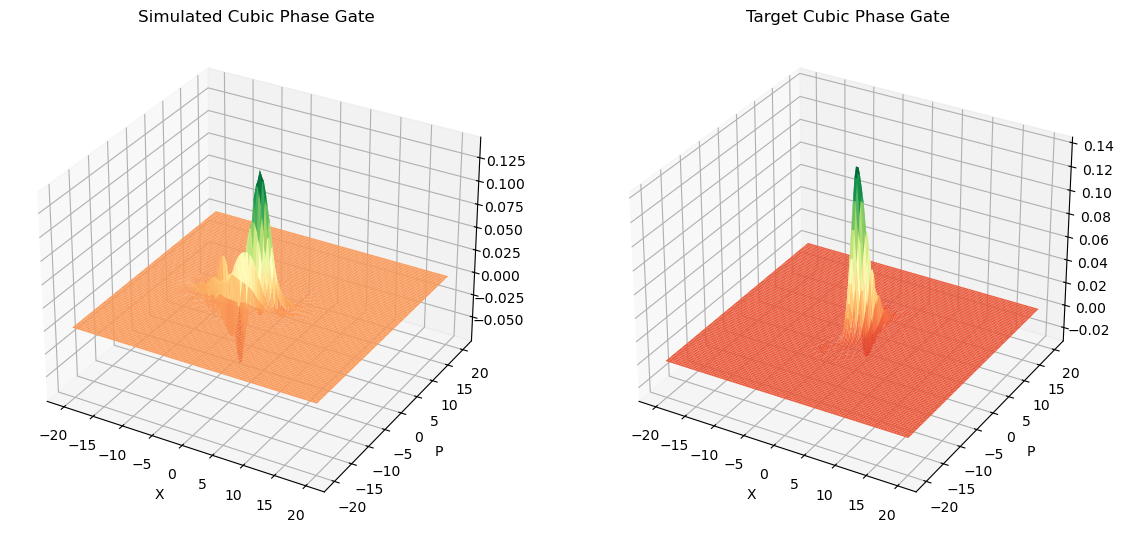

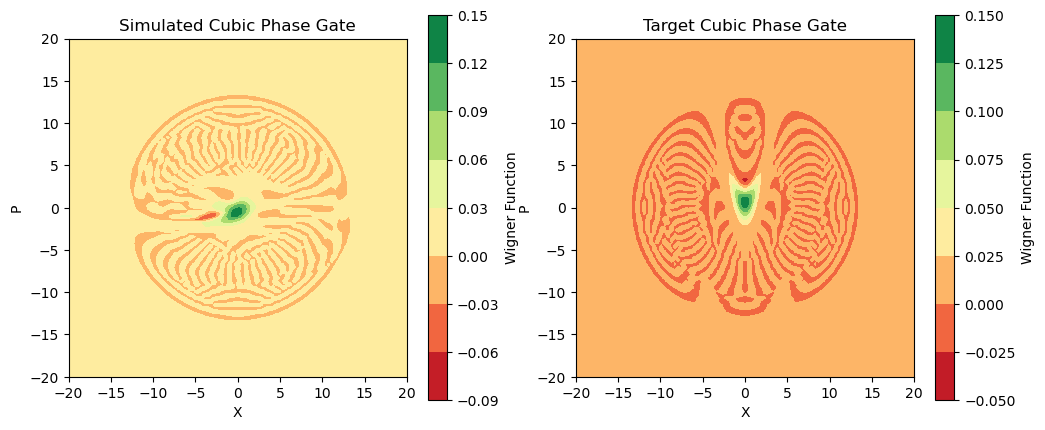

In [5]:
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state |0>
    
    """ Direct """
    Sgate(-np.log(lam), sqphi) | q[0] # apply the squeezing
    Dgate(r, phi) | q[0] # apply the displacement
    
    """ Nonlinearity """
    for i in range(N): # apply the small propagation step N times
        
        #Rgate(-chi/2*dt) | q[0]
        Kgate(nkappa) | q[0]
        Rgate(nrphi) | q[0]
        Dgate(nr, ndphi) | q[0]
        
    
    """ Inverse """
    Dgate(-r, phi) | q[0]
    Sgate(np.log(lam), sqphi) | q[0]
    
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim}) 
simstate = eng.run(prog).state


# determine actual cubic phase gate outcome
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state |0>
    Vgate(gamma) | q[0]
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
target_state = eng.run(prog).state


# plot the Wigner function of the simulated and target states
fig = plt.figure(figsize = (14, 7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax_plot_wigner(ax1, simstate, "Simulated Cubic Phase Gate")
ax_plot_wigner(ax2, target_state, "Target Cubic Phase Gate")
plt.show()

# plot 2d Wigner function
fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax_plot_wigner_2d(ax1, simstate, "Simulated Cubic Phase Gate")
ax_plot_wigner_2d(ax2, target_state, "Target Cubic Phase Gate")
plt.show()



Plot each step:

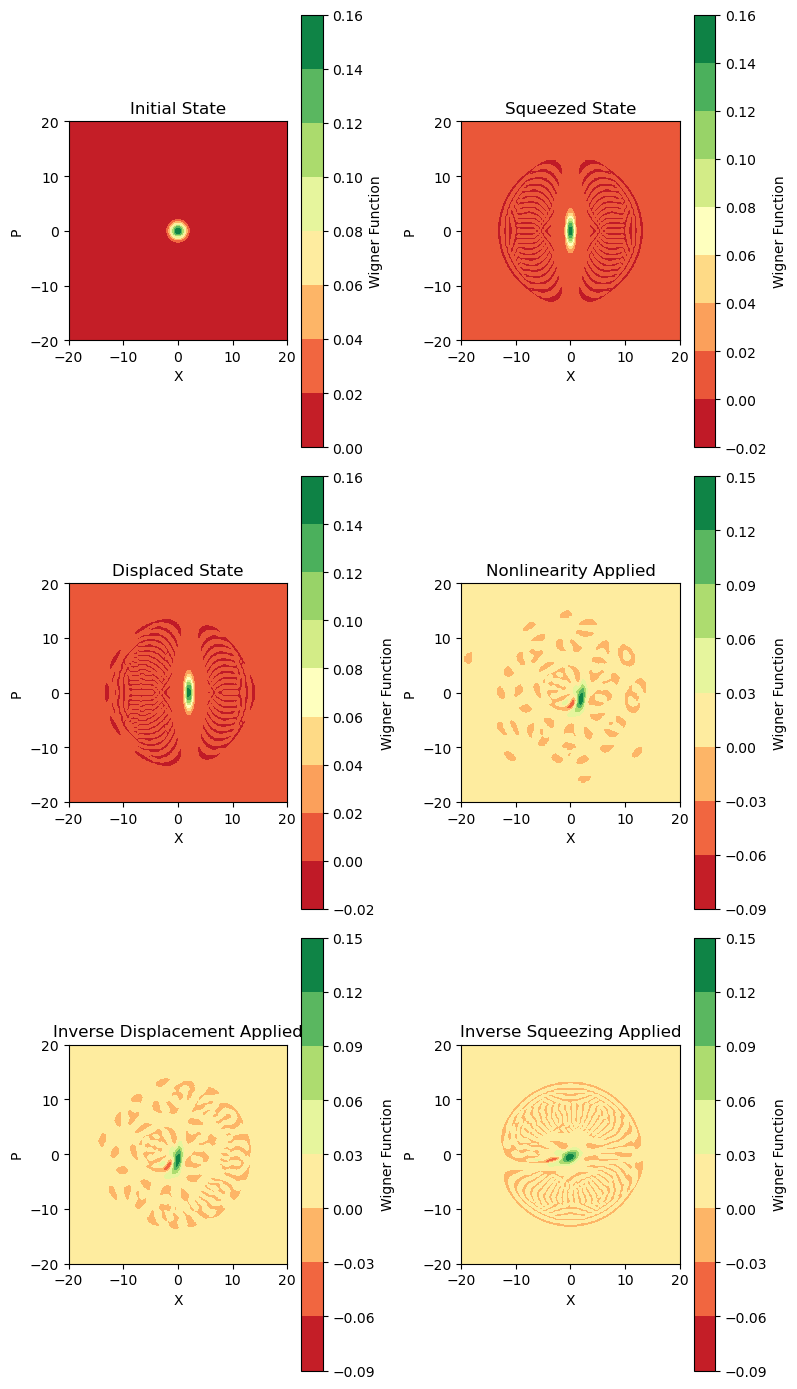

In [6]:

# initial
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state |0>
    
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim}) 
state0 = eng.run(prog).state   
 
# squeezed
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state |0>

    """ Direct """
    Sgate(-np.log(lam), sqphi) | q[0] # apply the squeezing

eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim}) 
state1 = eng.run(prog).state

# displaced
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state |0>

    """ Direct """
    Sgate(-np.log(lam), sqphi) | q[0] # apply the squeezing
    Dgate(r, phi) | q[0] # apply the displacement

eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim}) 
state2 = eng.run(prog).state
 
# nonlinearity
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state |0>

    """ Direct """
    Sgate(-np.log(lam), sqphi) | q[0] # apply the squeezing
    Dgate(r, phi) | q[0] # apply the displacement
    
    """ Nonlinearity """
    for i in range(N): # apply the small propagation step N times
        #Rgate(-chi/2*dt) | q[0]
        Kgate(nkappa) | q[0]
        Rgate(nrphi) | q[0]
        Dgate(nr, ndphi) | q[0]
        
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
state3 = eng.run(prog).state

# inverse displacement
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state |0>

    """ Direct """
    Sgate(-np.log(lam), sqphi) | q[0] # apply the squeezing
    Dgate(r, phi) | q[0] # apply the displacement
    
    """ Nonlinearity """
    for i in range(N): # apply the small propagation step N times
        #Rgate(-chi/2*dt) | q[0]
        Kgate(nkappa) | q[0]
        Rgate(nrphi) | q[0]
        Dgate(nr, ndphi) | q[0]
        
    
    """ Inverse """
    Dgate(-r, phi) | q[0]

eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
state4 = eng.run(prog).state

# inverse squeezing
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state |0>

    """ Direct """
    Sgate(-np.log(lam), sqphi) | q[0] # apply the squeezing
    Dgate(r, phi) | q[0] # apply the displacement
    
    """ Nonlinearity """
    for i in range(N): # apply the small propagation step N times
        
        #Rgate(-chi/2*dt) | q[0]
        Kgate(nkappa) | q[0]        
        Rgate(nrphi) | q[0]
        Dgate(nr, ndphi) | q[0]
        
    
    """ Inverse """
    Dgate(-r, phi) | q[0]
    Sgate(np.log(lam), sqphi) | q[0]
    
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim}) 
state5 = eng.run(prog).state




# # plot evolution of the Wigner function
# fig = plt.figure(figsize = (8, 14))
# ax1 = fig.add_subplot(321, projection='3d')
# ax2 = fig.add_subplot(322, projection='3d')
# ax3 = fig.add_subplot(323, projection='3d')
# ax4 = fig.add_subplot(324, projection='3d')
# ax5 = fig.add_subplot(325, projection='3d')
# ax6 = fig.add_subplot(326, projection='3d')

# ax_plot_wigner(ax1, state0, "Initial State")
# ax_plot_wigner(ax2, state1, "Squeezed State")
# ax_plot_wigner(ax3, state2, "Displaced State")
# ax_plot_wigner(ax4, state3, "Nonlinearity Applied")
# ax_plot_wigner(ax5, state4, "Inverse Displacement Applied")
# ax_plot_wigner(ax6, state5, "Inverse Squeezing Applied")

# fig.tight_layout()
# plt.show()

# plot evolution of the Wigner function 2D
fig = plt.figure(figsize = (8, 14))

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

ax_plot_wigner_2d(ax1, state0, "Initial State")
ax_plot_wigner_2d(ax2, state1, "Squeezed State")
ax_plot_wigner_2d(ax3, state2, "Displaced State")
ax_plot_wigner_2d(ax4, state3, "Nonlinearity Applied")
ax_plot_wigner_2d(ax5, state4, "Inverse Displacement Applied")
ax_plot_wigner_2d(ax6, state5, "Inverse Squeezing Applied")

fig.tight_layout()
plt.show()



Plot each step again, but this time also separate the different operations within the nonlinearity step

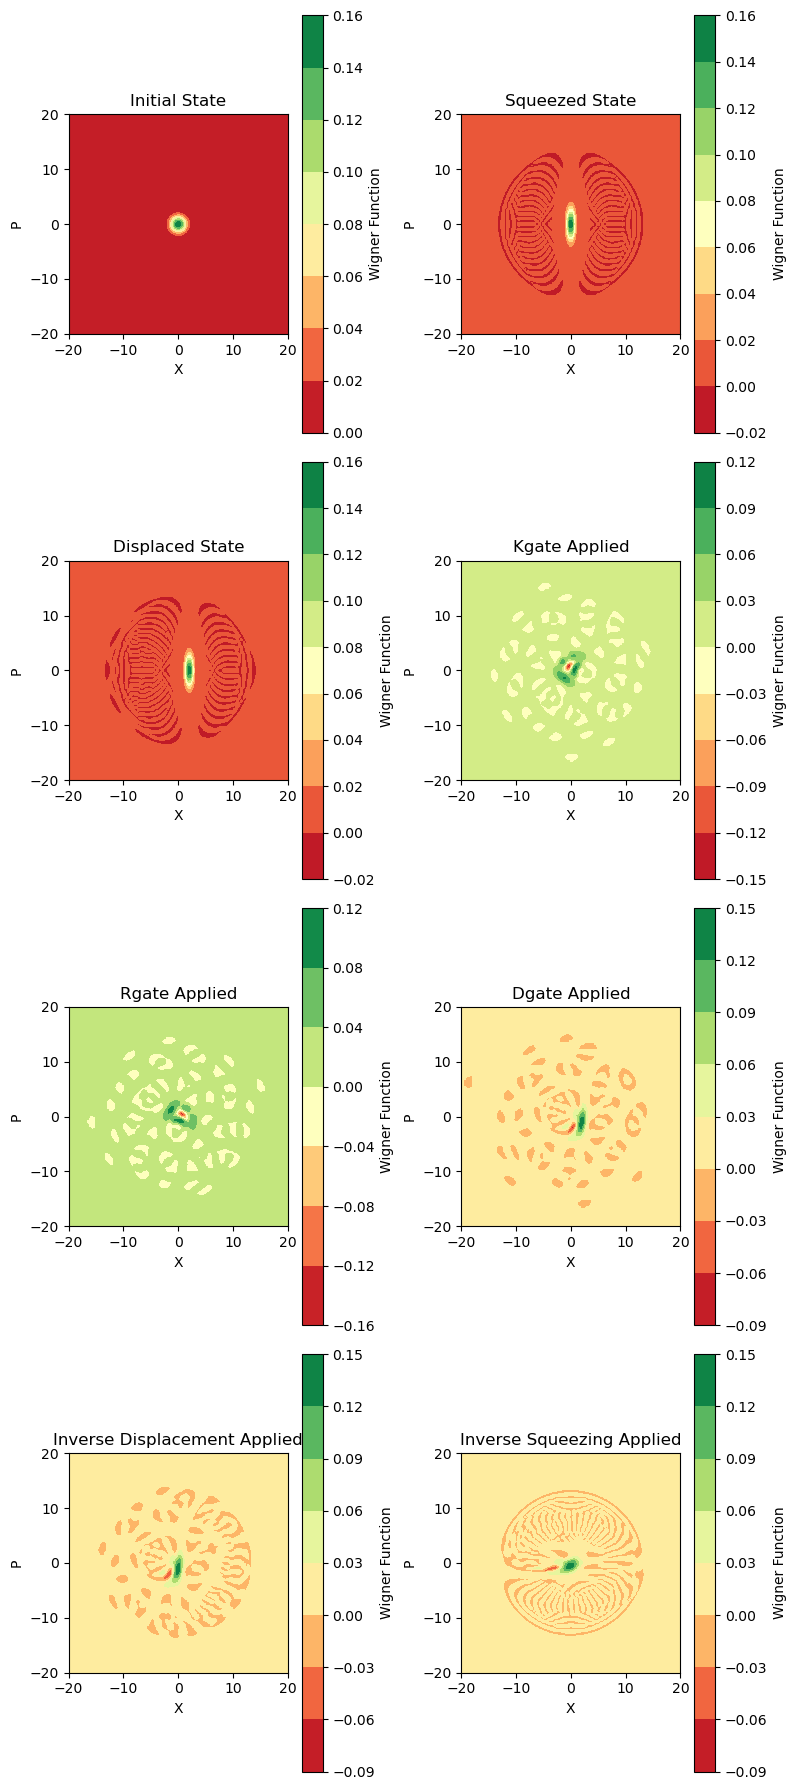

In [7]:
# Initial state
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0]  # Prepare the vacuum state |0>

eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
state0 = eng.run(prog).state


# Squeezed state
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0]
    Sgate(-np.log(lam), sqphi) | q[0]  # Apply the squeezing

eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
state1 = eng.run(prog).state


# Displaced state
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0]
    Sgate(-np.log(lam), sqphi) | q[0]
    Dgate(r, phi) | q[0]

eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
state2 = eng.run(prog).state


# Nonlinearity K (split into separate steps)
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0]
    Sgate(-np.log(lam), sqphi) | q[0]
    Dgate(r, phi) | q[0]

    # Apply nonlinearity in separate steps
    for i in range(N):
        #Rgate(-chi/2*dt) | q[0]
        Kgate(nkappa) | q[0]  # Kerr nonlinearity
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
state3_k = eng.run(prog).state


# Nonlinearity KR (split into separate steps)
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0]
    Sgate(-np.log(lam), sqphi) | q[0]
    Dgate(r, phi) | q[0]
    
    for i in range(N):
        #Rgate(-chi/2*dt) | q[0]
        Kgate(nkappa) | q[0]  # Kerr nonlinearity
        Rgate(nrphi) | q[0]  # Phase rotation
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
state3_r = eng.run(prog).state


# Nonlinearity KRD (split into separate steps)
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0]
    Sgate(-np.log(lam), sqphi) | q[0]
    Dgate(r, phi) | q[0]
    
    for i in range(N):
        #Rgate(-chi/2*dt) | q[0]
        Kgate(nkappa) | q[0]  # Kerr nonlinearity
        Rgate(nrphi) | q[0]  # Phase rotation
        Dgate(nr, ndphi) | q[0]  # Additional displacement

eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
state3_d = eng.run(prog).state


# inverse displacement
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state |0>

    """ Direct """
    Sgate(-np.log(lam), sqphi) | q[0] # apply the squeezing
    Dgate(r, phi) | q[0] # apply the displacement
    
    """ Nonlinearity """
    for i in range(N): # apply the small propagation step N times
        #Rgate(-chi/2*dt) | q[0]
        Kgate(nkappa) | q[0]
        Rgate(nrphi) | q[0]
        Dgate(nr, ndphi) | q[0]
        
    
    """ Inverse """
    Dgate(-r, phi) | q[0]

eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
state4 = eng.run(prog).state


# inverse squeezing
prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state |0>

    """ Direct """
    Sgate(-np.log(lam), sqphi) | q[0] # apply the squeezing
    Dgate(r, phi) | q[0] # apply the displacement
    
    """ Nonlinearity """
    for i in range(N): # apply the small propagation step N times
        #Rgate(-chi/2*dt) | q[0]
        Kgate(nkappa) | q[0]
        Rgate(nrphi) | q[0]
        Dgate(nr, ndphi) | q[0]
        
    
    """ Inverse """
    Dgate(-r, phi) | q[0]
    Sgate(np.log(lam), sqphi) | q[0]
    
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim}) 
state5 = eng.run(prog).state


# Plot evolution of the Wigner function in 2D
fig = plt.figure(figsize=(8, 18))

ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)
ax5 = fig.add_subplot(425)
ax6 = fig.add_subplot(426)
ax7 = fig.add_subplot(427)
ax8 = fig.add_subplot(428)

ax_plot_wigner_2d(ax1, state0, "Initial State")
ax_plot_wigner_2d(ax2, state1, "Squeezed State")
ax_plot_wigner_2d(ax3, state2, "Displaced State")
ax_plot_wigner_2d(ax4, state3_k, "Kgate Applied")
ax_plot_wigner_2d(ax5, state3_r, "Rgate Applied")
ax_plot_wigner_2d(ax6, state3_d, "Dgate Applied")
ax_plot_wigner_2d(ax7, state4, "Inverse Displacement Applied")
ax_plot_wigner_2d(ax8, state5, "Inverse Squeezing Applied")

fig.tight_layout()
plt.show()


#### **Use GKP State**

We use GKP state as in the paper using built-in SF [GKP states](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.GKP.html)

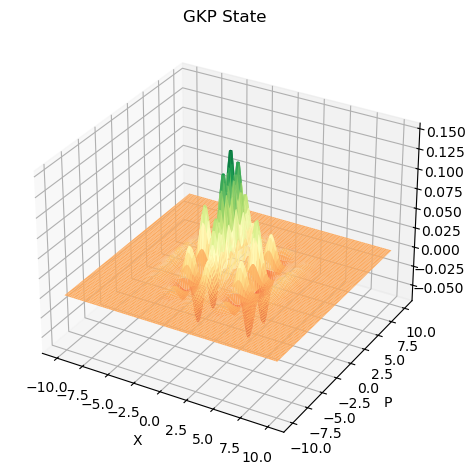

In [8]:
prog = sf.Program(1)
with prog.context as q:
    # prepare GKP state
    sf.ops.GKP([0, 0]) | q[0]
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
target_state = eng.run(prog).state

# plot the Wigner function of the GKP state
plot_wigner(target_state, "GKP State", range = 10)


### **Testing**

#### **Case 1: Instability of Fock Backend When Squeezing States**

When squeezing a state and using the `fock` backend instead of the `gaussian` backend, for high squeezing we get very different results.

Upon looking into this it seems that this is a known issue: 
- [Forum discussion](https://discuss.pennylane.ai/t/wigner-calculation-unstable-for-the-fock-backend/2293/3)

#### Starting with testing the intermediate outcome of our squeezing and displacement:

Parameters: r = 1 lam =  0.5


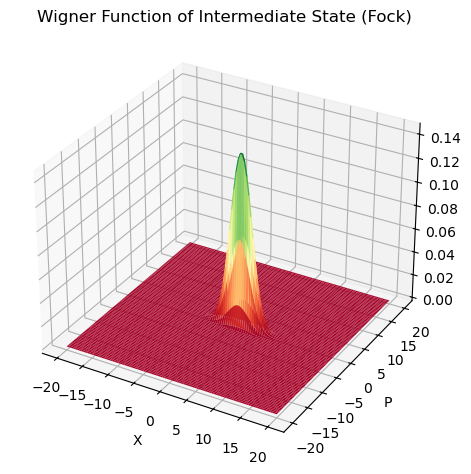

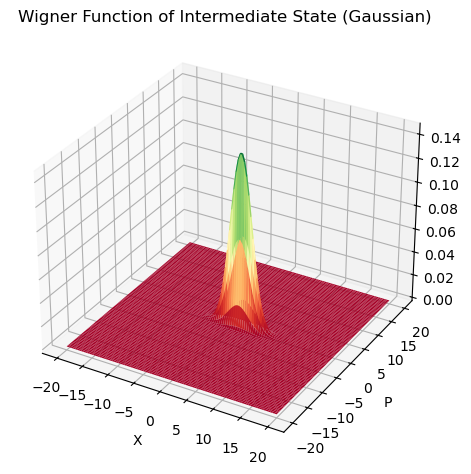

In [9]:
print("Parameters: r =", r, "lam = ", lam)

prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state |0>
    
    """ Direct """
    Sgate(np.log(lam), 0) | q[0] # apply the squeezing
    Dgate(r, phi) | q[0] # apply the displacement
    
    
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim}) 
state = eng.run(prog).state
plot_wigner(state, "Wigner Function of Intermediate State (Fock)")


prog = sf.Program(1)
with prog.context as q:
    Vac | q[0] # prepare the vacuum state |0>
    
    """ Direct """
    Sgate(np.log(lam), 0) | q[0] # apply the squeezing
    Dgate(r, phi) | q[0] # apply the displacement
    
    
eng = sf.Engine('gaussian') 
state = eng.run(prog).state
plot_wigner(state, "Wigner Function of Intermediate State (Gaussian)")

#### **Testing Cutoff Dimension Instability**

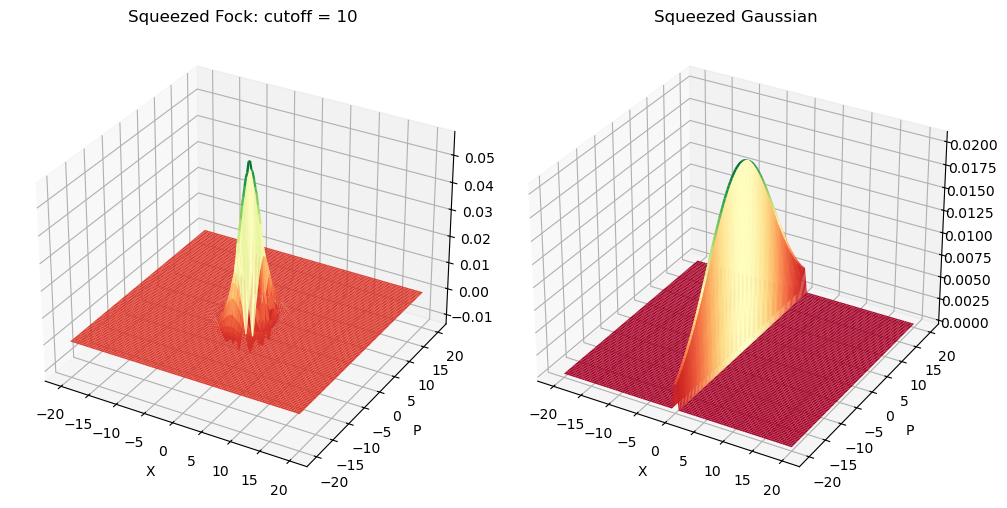

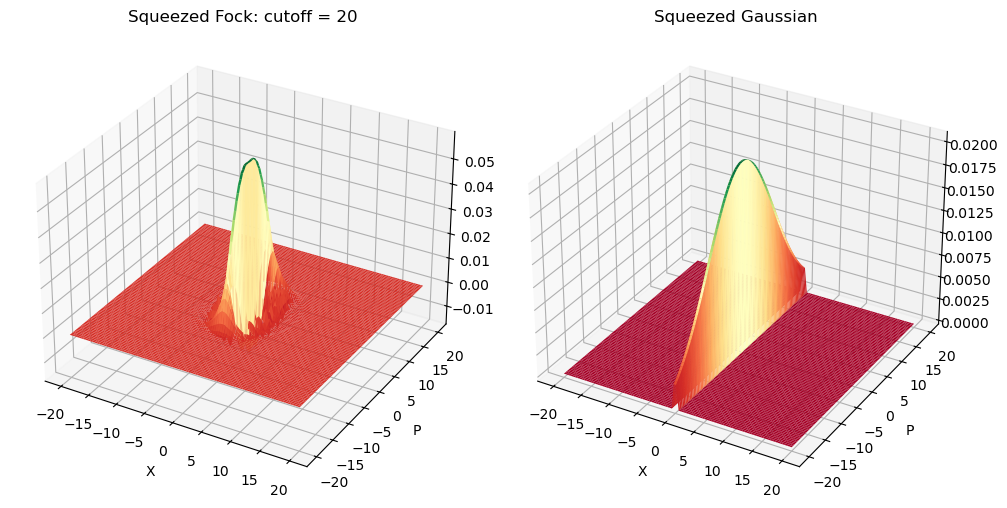

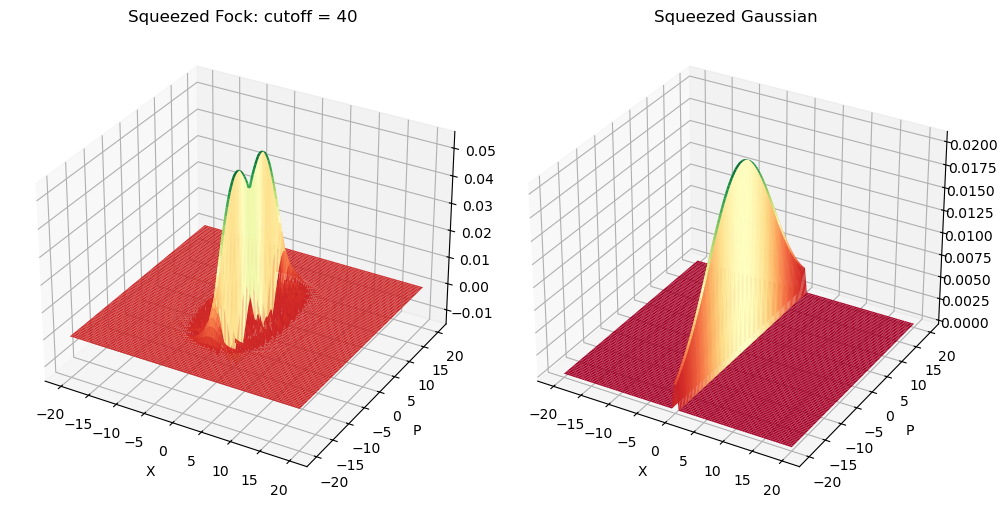

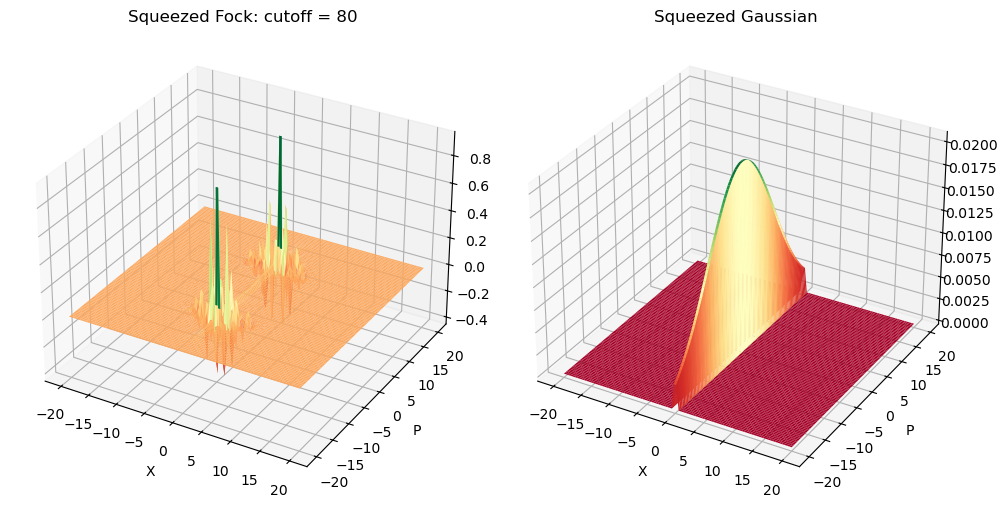

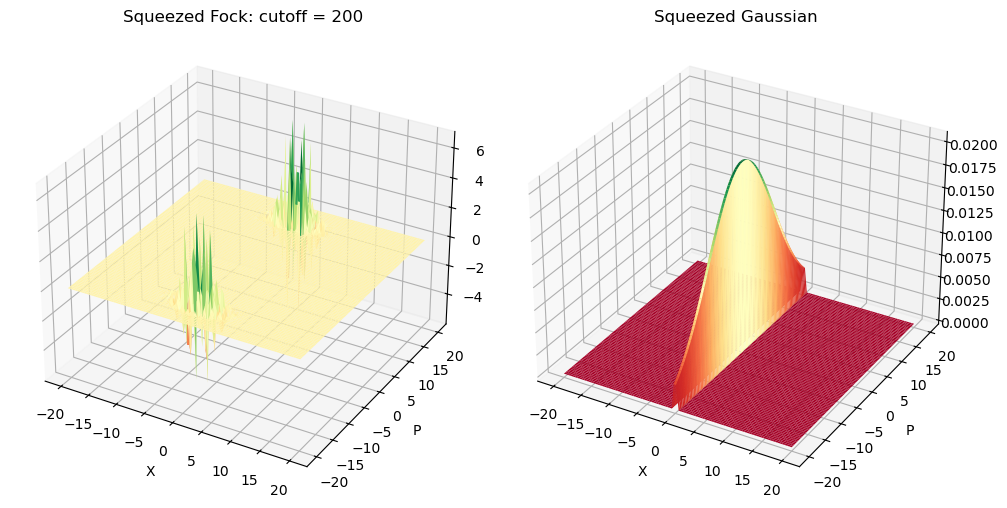

In [ ]:
lam = 10.0
cutoff_dim = [10, 20, 40, 80, 200, 400]

def squeeze_fock(lam, cutoff_dim):
    prog = sf.Program(1)
    with prog.context as q:
        Vac | q[0] # prepare the vacuum state |0>

        """ Direct """
        Sgate(np.log(lam), 0) | q[0] # apply the squeezing

    eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim}) 
    state = eng.run(prog).state
    return state

def squeeze_gaussian(lam, cutoff_dim):
    prog = sf.Program(1)
    with prog.context as q:
        Vac | q[0] # prepare the vacuum state |0>

        """ Direct """
        Sgate(np.log(lam), 0) | q[0] # apply the squeezing

    eng = sf.Engine('gaussian') 
    state = eng.run(prog).state
    return state

for i in range(len(cutoff_dim)):
    squeezedf = squeeze_fock(lam, cutoff_dim[i])
    squeezedg = squeeze_gaussian(lam, cutoff_dim[i])

    fig = plt.figure(figsize=(10, 5)) 
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    ax_plot_wigner(ax1, squeezedf, "Squeezed Fock: cutoff = " + str(cutoff_dim[i]))
    ax_plot_wigner(ax2, squeezedg, "Squeezed Gaussian")
    fig.tight_layout()
    plt.show()

#### **Testing Range of Representable Squeezing**

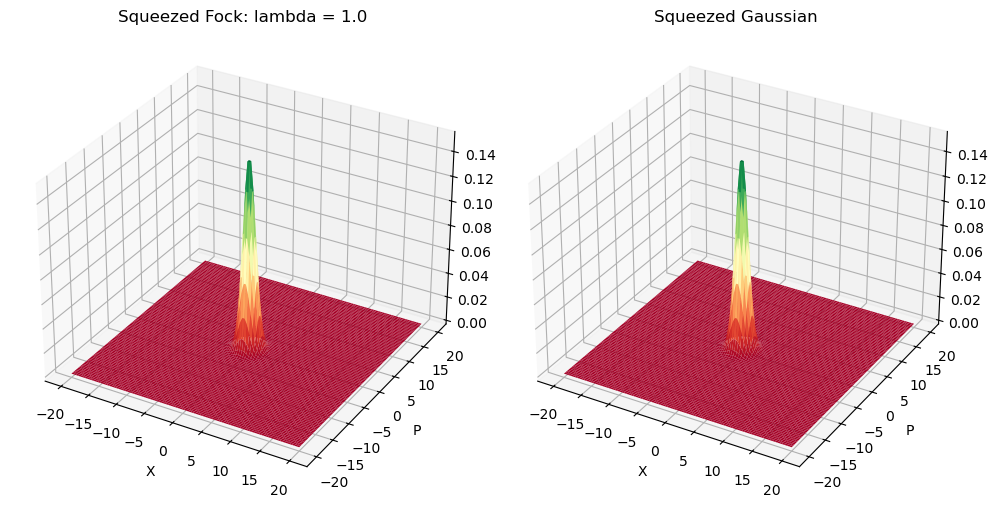

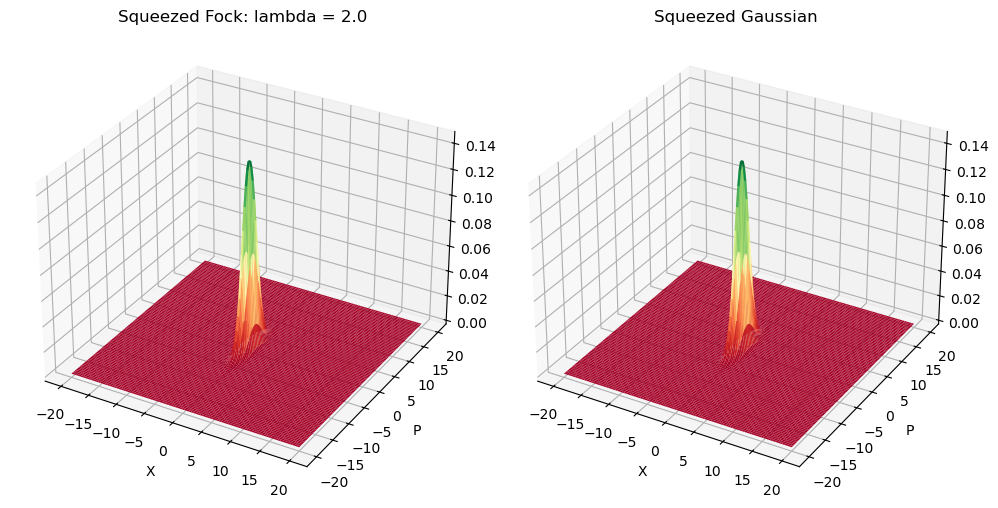

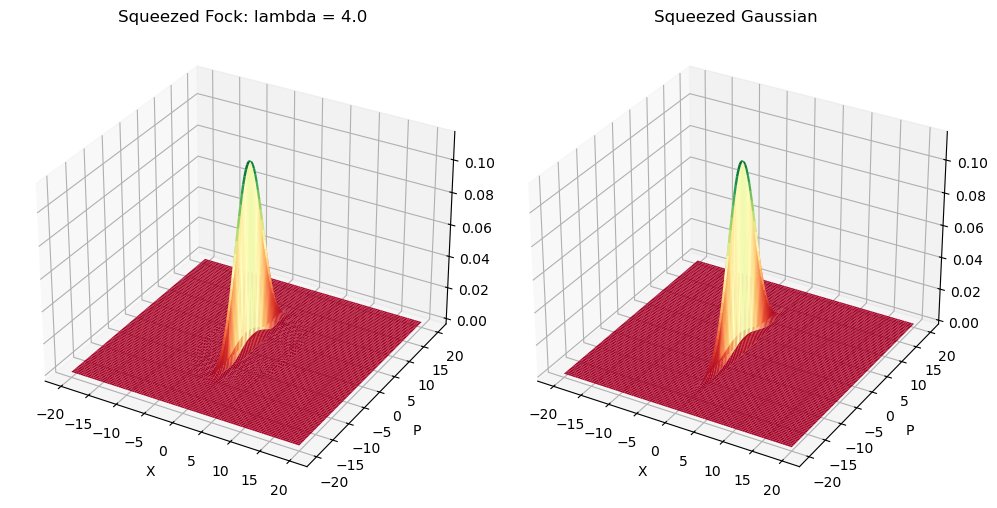

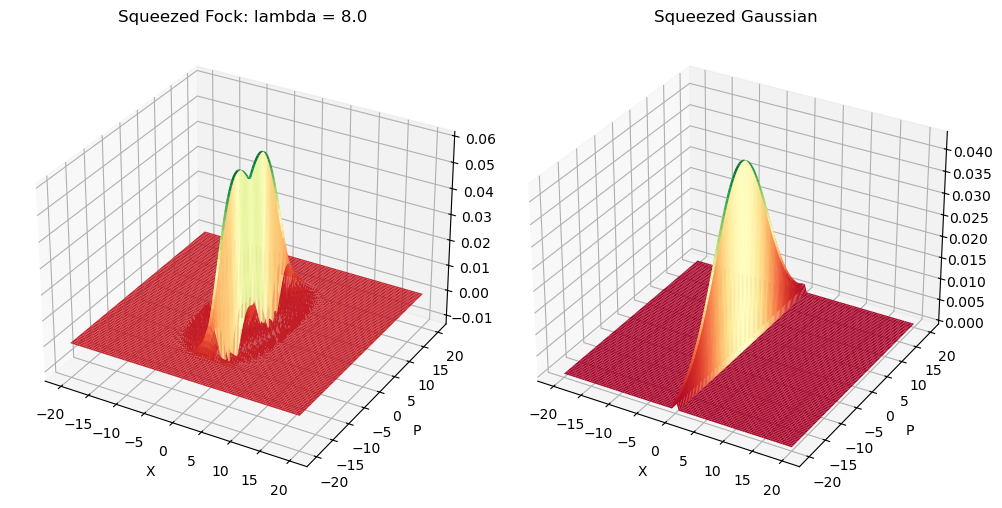

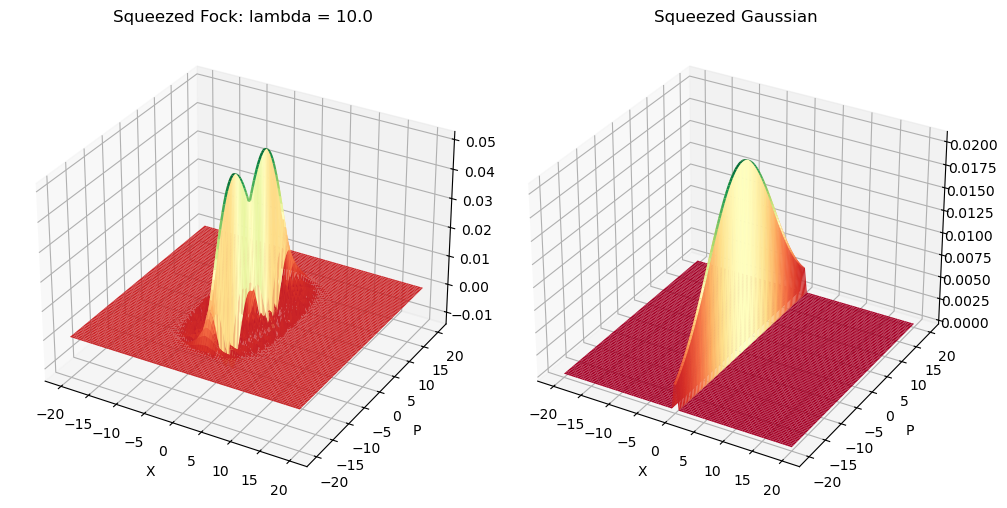

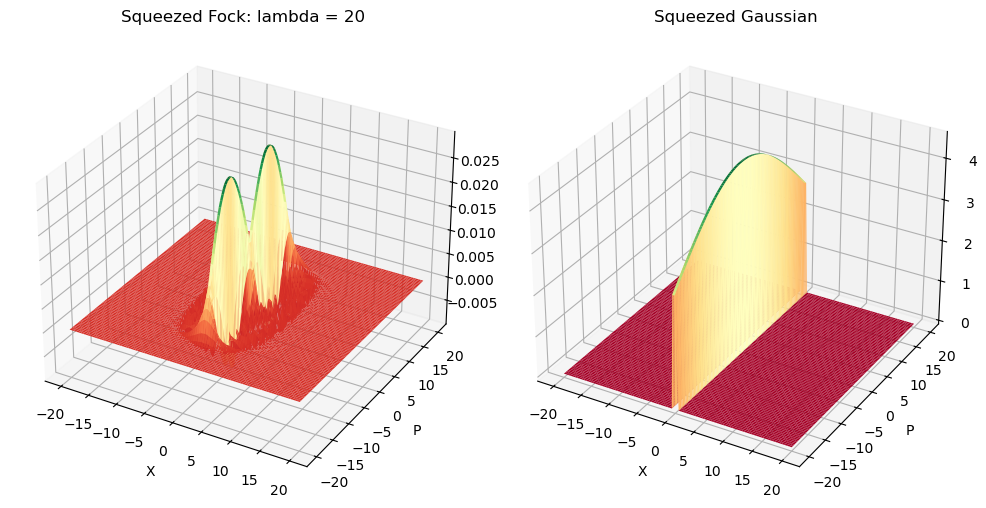

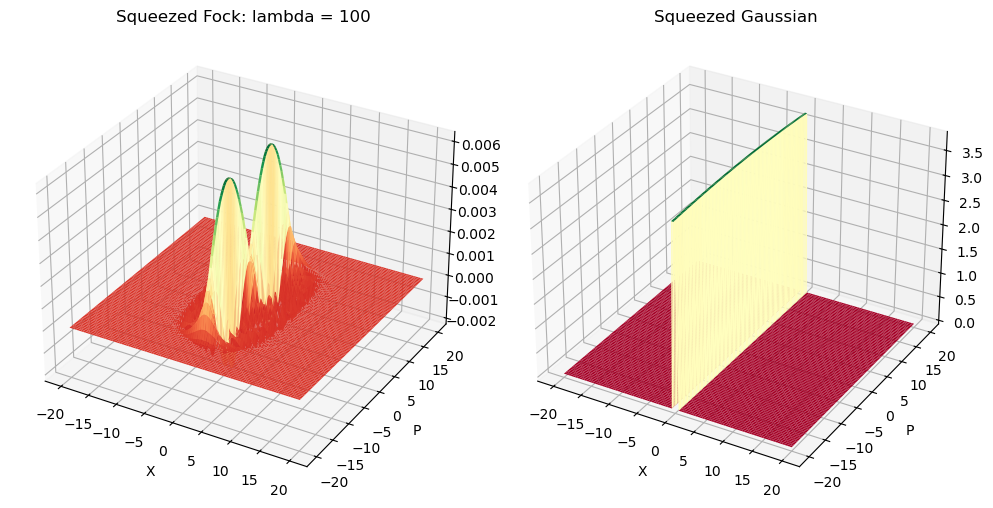

In [72]:
squeezing = [1.0, 2.0, 4.0, 8.0, 10.0, 20, 100]
cutoff_dim = 50

def squeeze_fock(lam, cutoff_dim):
    prog = sf.Program(1)
    with prog.context as q:
        Vac | q[0] # prepare the vacuum state |0>

        """ Direct """
        Sgate(np.log(lam), 0) | q[0] # apply the squeezing

    eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim}) 
    state = eng.run(prog).state
    return state

def squeeze_gaussian(lam):
    prog = sf.Program(1)
    with prog.context as q:
        Vac | q[0] # prepare the vacuum state |0>

        """ Direct """
        Sgate(np.log(lam), 0) | q[0] # apply the squeezing

    eng = sf.Engine('gaussian') 
    state = eng.run(prog).state
    return state

for i in range(len(squeezing)):
    squeezedf = squeeze_fock(squeezing[i], cutoff_dim)
    squeezedg = squeeze_gaussian(squeezing[i])

    fig = plt.figure(figsize=(10, 5)) 
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    ax_plot_wigner(ax1, squeezedf, "Squeezed Fock: lambda = " + str(squeezing[i]))
    ax_plot_wigner(ax2, squeezedg, "Squeezed Gaussian")
    fig.tight_layout()
    plt.show()

#### **Testing displacement ranges**

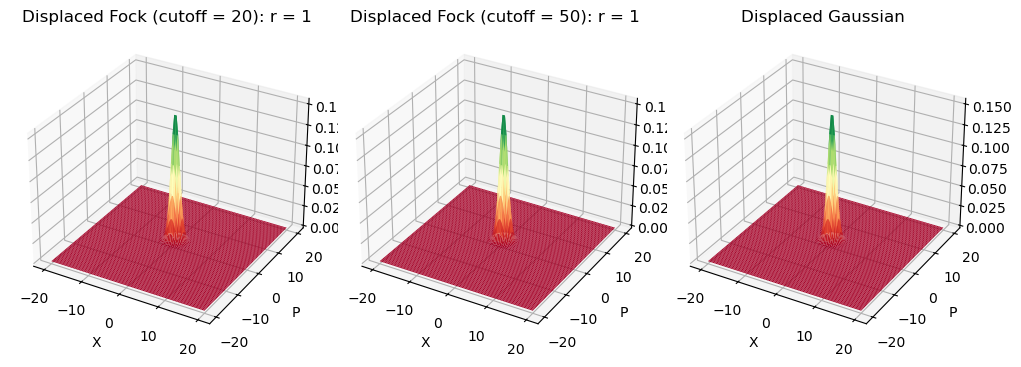

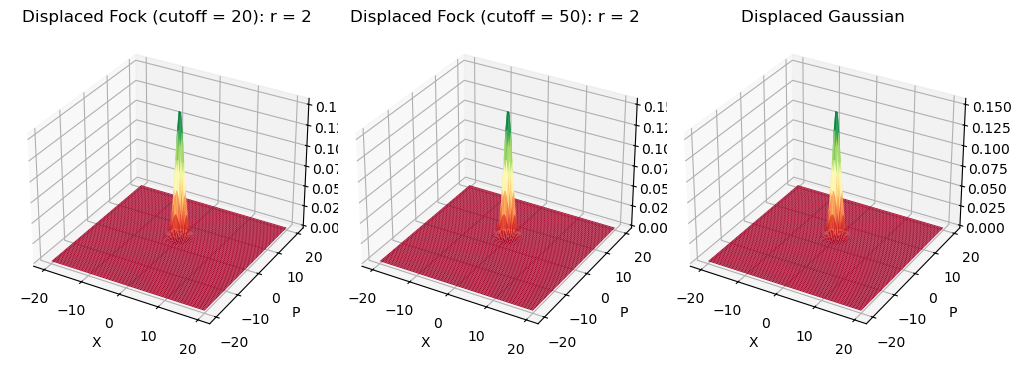

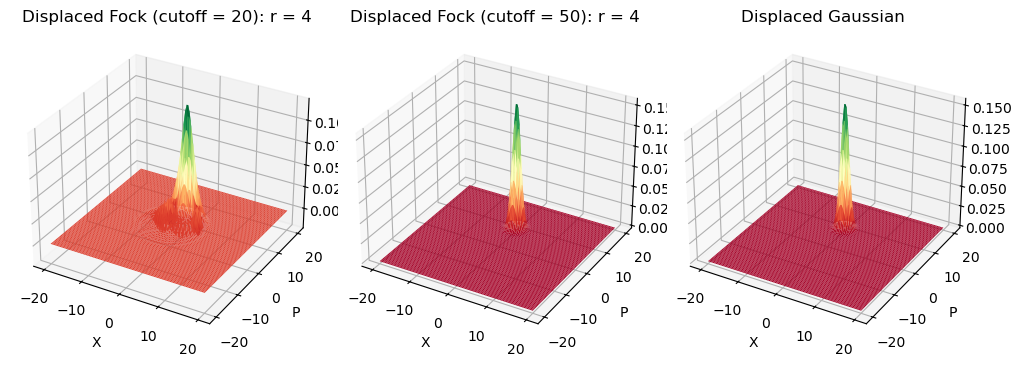

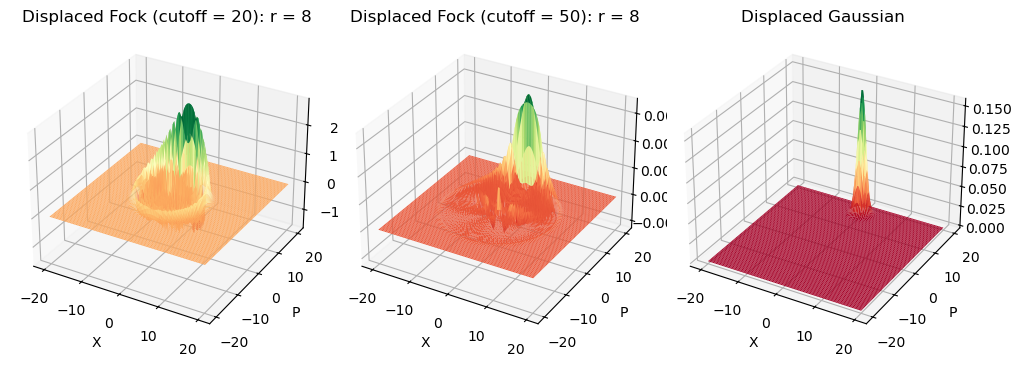

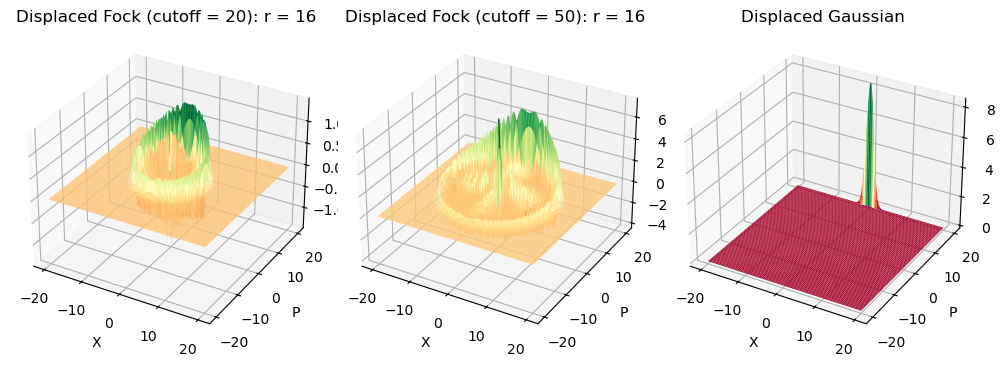

In [73]:
displacement = [1, 2, 4, 8, 16]

def displace_fock20(r, phi):
    prog = sf.Program(1)
    with prog.context as q:
        Vac | q[0] # prepare the vacuum state |0>

        """ Direct """
        Dgate(r, phi) | q[0] # apply the displacement

    eng = sf.Engine('fock', backend_options={"cutoff_dim": 20}) 
    state = eng.run(prog).state
    return state

def displace_fock50(r, phi):
    prog = sf.Program(1)
    with prog.context as q:
        Vac | q[0] # prepare the vacuum state |0>

        """ Direct """
        Dgate(r, phi) | q[0] # apply the displacement

    eng = sf.Engine('fock', backend_options={"cutoff_dim": 50}) 
    state = eng.run(prog).state
    return state

def displace_gaussian(r, phi):
    prog = sf.Program(1)
    with prog.context as q:
        Vac | q[0] # prepare the vacuum state |0>

        """ Direct """
        Dgate(r, phi) | q[0] # apply the displacement

    eng = sf.Engine('gaussian') 
    state = eng.run(prog).state
    return state

for i in range(len(displacement)):
    displacedf20 = displace_fock20(displacement[i], np.pi/2)
    displacedf50 = displace_fock50(displacement[i], np.pi/2)
    displacedg = displace_gaussian(displacement[i], np.pi/2)

    fig = plt.figure(figsize=(10, 5)) 
    ax1 = fig.add_subplot(131, projection='3d')
    ax2 = fig.add_subplot(132, projection='3d')
    ax3 = fig.add_subplot(133, projection='3d')
    ax_plot_wigner(ax1, displacedf20, "Displaced Fock (cutoff = 20): r = " + str(displacement[i]))
    ax_plot_wigner(ax2, displacedf50, "Displaced Fock (cutoff = 50): r = " + str(displacement[i]))
    ax_plot_wigner(ax3, displacedg, "Displaced Gaussian")

    fig.tight_layout()
    plt.show()

#### **Conclusions:**
1) Increasing the `cutoff_dim` for the `fock` basis leads to larger representable displacement values $\alpha$, but may lead to quicker numerical instability for highly squeezed states.
2) A `cutoff_dim` of 50 does not yet have a numerical isntability and is able to represent dispacements as large as $r = 4$, and squeezing as large as $\lambda = 4$ (these limits could be made more precise). This could be etiher from the fock basis not being able to represent highly squeezed or displaced states (most likely) or from the operations being unstable in squeezing or displacing in the fock basis.

### **Questions**

1) What are the expected/typical displacement and squeezing parameters $\alpha$, $\lambda$
2) Is Kerr gate really representative of the nonlinearity in the driven Kerr Hamiltonian?
3) What is a typical value for Kerr nonlinearity $\chi$

- It seems like changing `N` - discretization order, doesn't affect outcome